# Graph-Based Community Detection using Louvain Algorithm

In [172]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import community.community_louvain as community_louvain
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches
import time
import tracemalloc
from datasketch import MinHashLSH, MinHash

# Set display options
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## **Graph-Based Community Detection using Louvain Algorithm**

This section creates a network graph of similar players and uses the Louvain algorithm to detect communities/clusters.


In [173]:
def build_comprehensive_similarity_graph(query_player_name, results_df, X_data, 
                                        df_data, player_name_to_idx_map, 
                                        similarity_threshold=0.7):

    G = nx.Graph()
    
    # Get all player names from results
    player_names = results_df['name'].tolist()
    
    # Get indices and vectors for all players
    player_indices = []
    player_vectors = []
    
    for player_name in player_names:
        if player_name in player_name_to_idx_map:
            idx = player_name_to_idx_map[player_name]
            player_indices.append(idx)
            player_vectors.append(X_data[idx])
    
    if len(player_vectors) == 0:
        return G
    
    player_vectors = np.array(player_vectors)
    
    # Compute pairwise cosine similarities
    similarity_matrix = cosine_similarity(player_vectors)
    
    # Add nodes with attributes
    for i, player_name in enumerate(player_names):
        if player_name in player_name_to_idx_map:
            idx = player_name_to_idx_map[player_name]
            row = df_data.iloc[idx]
            node_attrs = {
                'name': player_name,
                'position': row.get('position', 'Unknown'),
                'rating': row.get('rating', 0),
                'is_query': (player_name == query_player_name)
            }
            G.add_node(player_name, **node_attrs)
    
    # Add edges based on similarity matrix
    for i in range(len(player_names)):
        for j in range(i+1, len(player_names)):
            similarity = similarity_matrix[i][j]
            if similarity >= similarity_threshold:
                G.add_edge(player_names[i], player_names[j], 
                          weight=similarity, similarity=similarity)
    
    return G


In [174]:
def detect_communities_louvain(G):
    if len(G.nodes()) == 0:
        return {}
    
    # Apply Louvain algorithm
    communities = community_louvain.best_partition(G)
    
    return communities


In [175]:
def visualize_network_graph(G, communities, query_player_name, layout='spring', figsize=(16, 16)):

    if len(G.nodes()) == 0:
        print("Graph is empty. Cannot visualize.")
        return
    
    # Create a single centered figure with better styling
    fig = plt.figure(figsize=figsize, facecolor='#f8f9fa', edgecolor='none')
    ax = fig.add_subplot(111, facecolor='#f8f9fa')
    
    # Get unique communities
    unique_communities = set(communities.values())
    n_communities = len(unique_communities)
    
    # Create beautiful color map for communities using vibrant colors
    if n_communities > 0:
        if n_communities <= 10:
            color_palette = plt.cm.Set3(np.linspace(0, 1, max(10, n_communities)))
        else:
            color_palette = plt.cm.tab20(np.linspace(0, 1, n_communities))
        community_colors = {comm: color_palette[i % len(color_palette)] 
                           for i, comm in enumerate(sorted(unique_communities))}
    else:
        community_colors = {0: '#3498db'}
    
    # Assign colors to nodes
    node_colors = []
    for node in G.nodes():
        comm_id = communities.get(node, 0)
        color = community_colors.get(comm_id, '#95a5a6')
        node_colors.append(color)
    
    # Highlight query player with a distinctive color
    query_color = '#e74c3c'  # Bright red
    query_edge_color = '#c0392b'  # Darker red for edge
    node_colors = [query_color if node == query_player_name else color 
                   for node, color in zip(G.nodes(), node_colors)]
    
    # Get node sizes based on rating
    base_size = 800
    node_sizes = [max(300, G.nodes[node].get('rating', 7) * base_size / 10) for node in G.nodes()]
    query_multiplier = 2.5
    node_sizes = [size * query_multiplier if node == query_player_name else size 
                  for node, size in zip(G.nodes(), node_sizes)]
    
    # Choose layout
    if layout == 'spring':
        pos = nx.spring_layout(G, k=3, iterations=100, seed=42, center=(0, 0), scale=1.2)
    elif layout == 'circular':
        pos = nx.circular_layout(G, scale=1.2, center=(0, 0))
    elif layout == 'kamada_kawai':
        try:
            pos = nx.kamada_kawai_layout(G, scale=1.2, center=(0, 0))
        except:
            pos = nx.spring_layout(G, k=3, iterations=100, seed=42, center=(0, 0), scale=1.2)
    else:
        pos = nx.spring_layout(G, k=3, iterations=100, seed=42, center=(0, 0), scale=1.2)
    
    # Identify hubs for edge coloring (similar to backbone graph)
    degrees = dict(G.degree())
    # Get top nodes by degree as hubs (top 20% or at least top 3)
    sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
    top_k_hubs = max(3, int(len(sorted_nodes) * 0.2))
    hub_set = set([node for node, _ in sorted_nodes[:top_k_hubs]])
    
    # Draw edges with simple styling (like backbone comparison)
    edge_colors = []
    for u, v in G.edges():
        # Color edges connecting hubs differently (like backbone comparison)
        if u in hub_set or v in hub_set:
            edge_colors.append('#e74c3c')  # Red for hub connections
        else:
            edge_colors.append('#3498db')  # Blue for regular connections
    
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color=edge_colors, 
                          alpha=0.4, width=0.5, arrows=False)
    
    # Draw nodes
    for node, size, color in zip(G.nodes(), node_sizes, node_colors):
        if node == query_player_name:
            nx.draw_networkx_nodes(G, {node: pos[node]}, 
                                  nodelist=[node], ax=ax,
                                  node_size=size, node_color=[color],
                                  alpha=0.95, edgecolors=query_edge_color,
                                  linewidths=4)
        else:
            nx.draw_networkx_nodes(G, {node: pos[node]}, 
                                  nodelist=[node], ax=ax,
                                  node_size=size, node_color=[color],
                                  alpha=0.85, edgecolors='white',
                                  linewidths=2.5)
    
    # Draw labels
    labels = {}
    for node in G.nodes():
        name = node
        if len(name) > 20:
            name = name[:17] + '...'
        labels[node] = name
    
    for node, label in labels.items():
        if node == query_player_name:
            nx.draw_networkx_labels(G, {node: pos[node]}, 
                                   labels={node: label}, ax=ax,
                                   font_size=11, font_weight='bold',
                                   font_color='white',
                                   bbox=dict(boxstyle='round,pad=0.3', 
                                           facecolor=query_edge_color,
                                           alpha=0.8, edgecolor='white', linewidth=2))
        else:
            nx.draw_networkx_labels(G, {node: pos[node]}, 
                                   labels={node: label}, ax=ax,
                                   font_size=9, font_weight='bold',
                                   font_color='#2c3e50',
                                   bbox=dict(boxstyle='round,pad=0.2', 
                                           facecolor='white',
                                           alpha=0.7, edgecolor='gray', linewidth=1))
    
    # Create legend
    legend_elements = []
    for comm_id in sorted(unique_communities):
        comm_nodes = [node for node, c in communities.items() if c == comm_id]
        color = community_colors[comm_id]
        comm_name = f"Community {comm_id} ({len(comm_nodes)} players)"
        legend_elements.append(mpatches.Patch(facecolor=color, edgecolor='white',
                                             linewidth=2, label=comm_name, alpha=0.8))
    
    legend_elements.append(mpatches.Patch(facecolor=query_color, edgecolor=query_edge_color,
                                         linewidth=3, label='Query Player', alpha=0.95))
    
    legend = ax.legend(handles=legend_elements, loc='upper left', 
                      fontsize=10, framealpha=0.95, 
                      fancybox=True, shadow=True,
                      edgecolor='gray', facecolor='white')
    legend.get_frame().set_linewidth(2)
    
    # Remove axes
    ax.axis('off')
    ax.set_xlim([min([p[0] for p in pos.values()]) * 1.15, 
                 max([p[0] for p in pos.values()]) * 1.15])
    ax.set_ylim([min([p[1] for p in pos.values()]) * 1.15, 
                 max([p[1] for p in pos.values()]) * 1.15])
    
    # Add title
    title = f'Player Similarity Network\nQuery: {query_player_name}'
    ax.text(0.5, 0.98, title, transform=ax.transAxes, 
            fontsize=18, fontweight='bold', ha='center', va='top',
            color='#2c3e50', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return fig


In [179]:
def display_similar_players_with_network_graph(player_name, n_similar=10, similarity_threshold=0.7, 
                                            show_performance=True, show_graph=False, 
                                            show_network=True, layout='spring',
                                            lsh=None, minhash_list=None, X_data=None, 
                                            df_data=None, player_name_to_idx_map=None,
                                            find_similar_players_lsh=None, visualize_similar_players=None):

    results, exec_time, mem_usage = find_similar_players_lsh(
            player_name, n_similar=n_similar, lsh=lsh, minhash_list=minhash_list,
            X_data=X_data, df_data=df_data, player_name_to_idx_map=player_name_to_idx_map
        )
        
    query_player = results.iloc[0]
        
    print(f"Query Player: {query_player['name']} ({query_player['position']})")
    if 'cluster_name' in results.columns:
        print(f"Cluster: {query_player.get('cluster_name', 'N/A')}")
    print(f"Rating: {query_player['rating']:.2f}")
    print(f"{'='*80}\n")
        
    # Show original visualization if requested
    if show_graph and visualize_similar_players is not None:
        visualize_similar_players(results, query_player['name'], n_similar=n_similar)
        
    G = build_comprehensive_similarity_graph(
        query_player['name'], 
        results, 
        X_data=X_data,
        df_data=df_data,
        player_name_to_idx_map=player_name_to_idx_map,
        similarity_threshold=similarity_threshold
    )
        
    if len(G.nodes()) > 0:
        # Detect communities using Louvain algorithm
        print("Detecting communities using Louvain algorithm...")
        communities = detect_communities_louvain(G)
            
        print(f"Found {len(set(communities.values()))} communities")
        print(f"Graph has {len(G.nodes())} nodes and {len(G.edges())} edges\n")
            
        # Visualize network graph with communities
        if show_network:
            visualize_network_graph(G, communities, query_player['name'], layout=layout)

        unique_communities = set(communities.values())
        for comm_id in sorted(unique_communities):
            comm_nodes = [node for node, c in communities.items() if c == comm_id]
            print(f"\nCommunity {comm_id} ({len(comm_nodes)} players):")
            for node in comm_nodes[:10]:  # Show first 10 players
                pos = G.nodes[node].get('position', 'Unknown')
                rating = G.nodes[node].get('rating', 0)
                is_query = " (Query)" if node == query_player['name'] else ""
                print(f"  • {node} ({pos}) - Rating: {rating:.2f}{is_query}")
            if len(comm_nodes) > 10:
                print(f"  ... and {len(comm_nodes) - 10} more players")

    else:
        print("Graph is empty. Not enough similarity connections.")
        
    return results, G, communities

### **Sample Usage**


Query Player: Manuel Neuer (GK)
Cluster: GK
Rating: 7.05

Detecting communities using Louvain algorithm...
Found 1 communities
Graph has 21 nodes and 210 edges



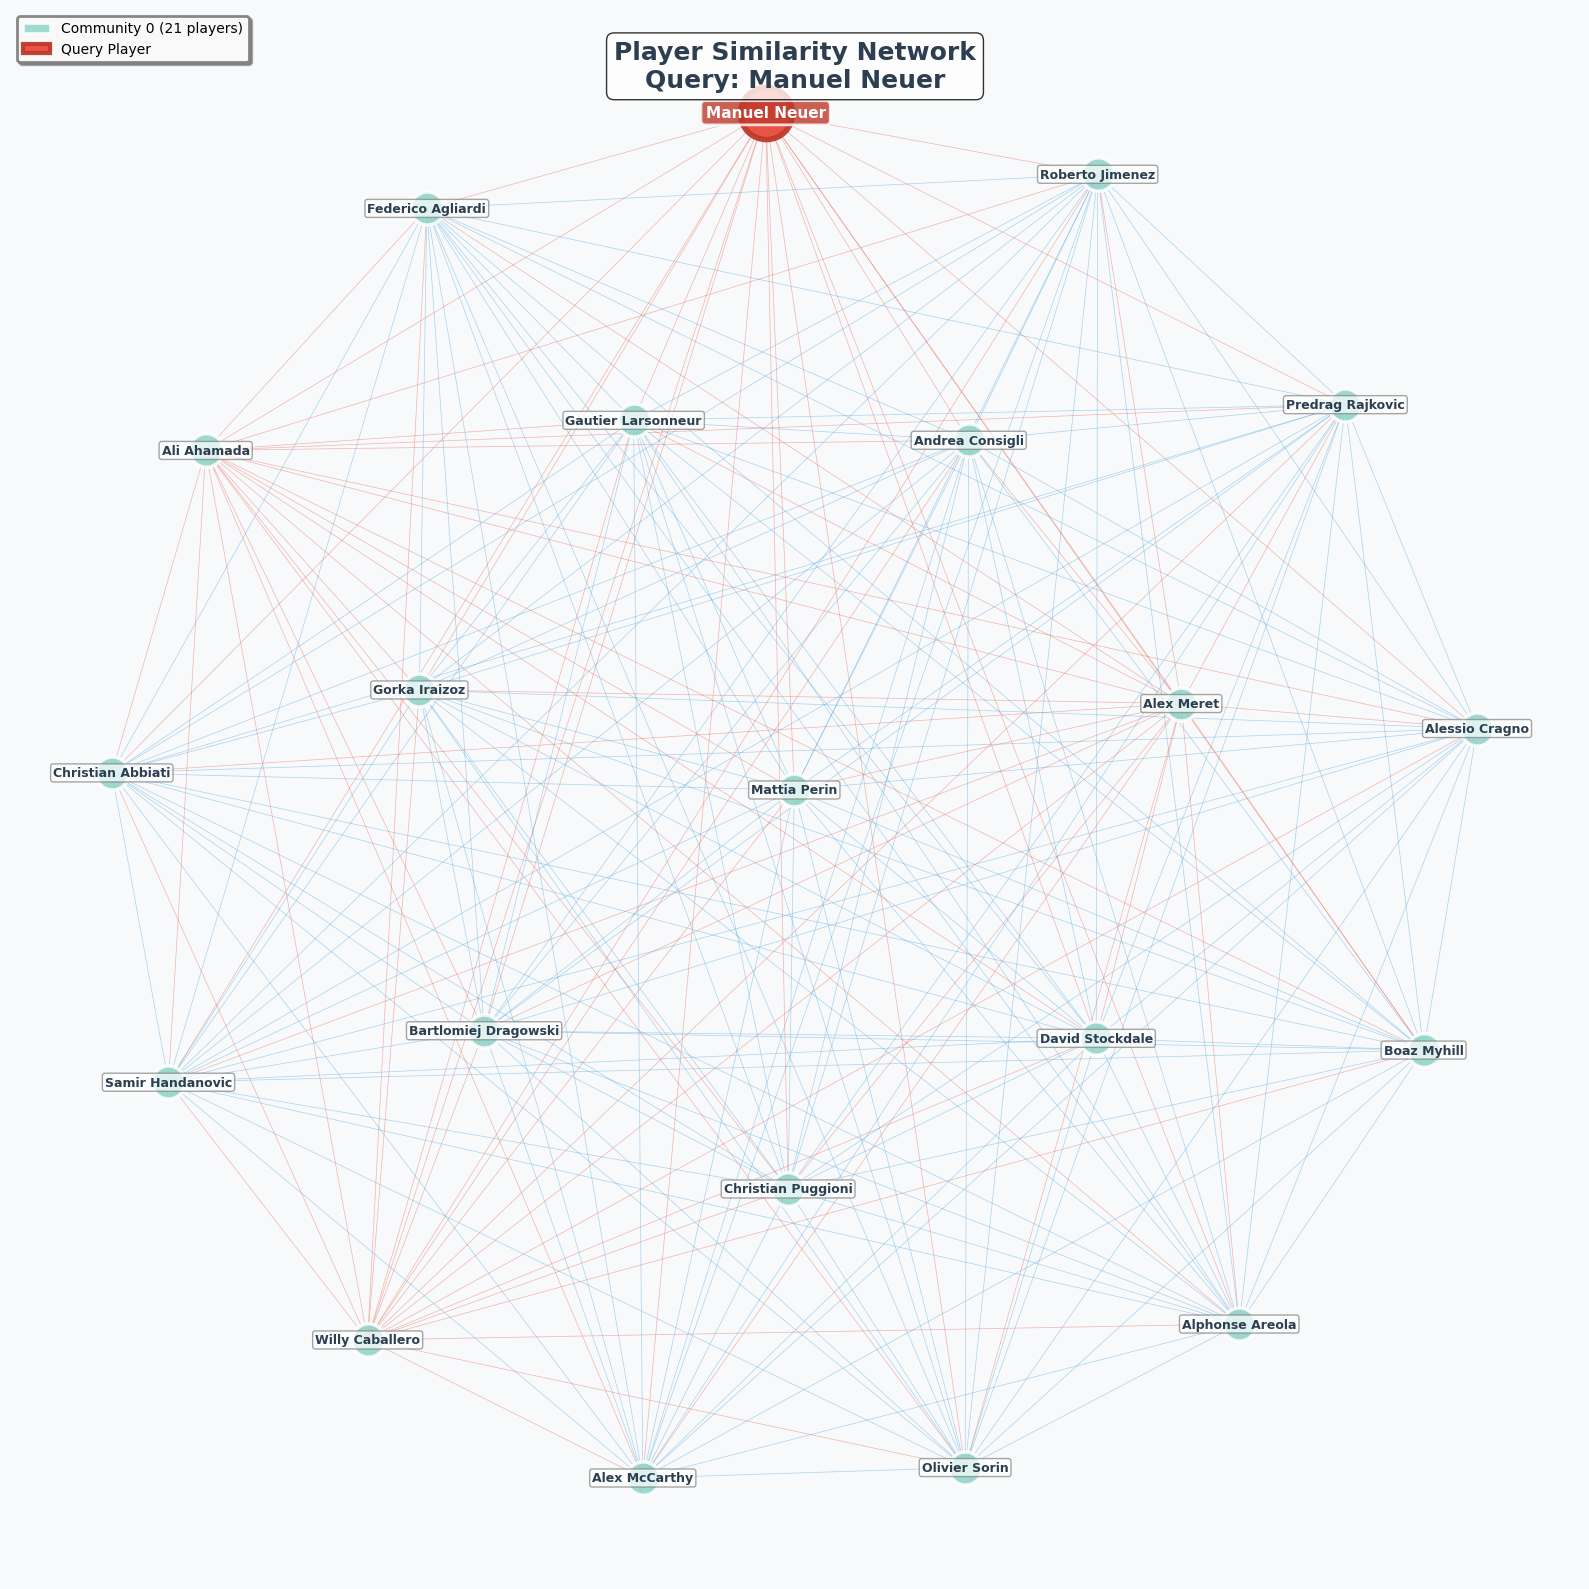


Community 0 (21 players):
  • Manuel Neuer (GK) - Rating: 7.05 (Query)
  • Alex Meret (GK) - Rating: 7.02
  • Willy Caballero (GK) - Rating: 7.16
  • Ali Ahamada (GK) - Rating: 7.27
  • Andrea Consigli (GK) - Rating: 7.10
  • Federico Agliardi (GK) - Rating: 7.07
  • Boaz Myhill (GK) - Rating: 7.36
  • Samir Handanovic (GK) - Rating: 7.04
  • Mattia Perin (GK) - Rating: 7.00
  • Christian Puggioni (GK) - Rating: 7.26
  ... and 11 more players


NoneType: None


In [181]:
player_name = "Manuel Neuer"
n_similar = 20
    
results, graph, communities = display_similar_players_with_network_graph(
    player_name, 
    n_similar=n_similar,
    similarity_threshold=0.7,
    show_performance=True,
    show_graph=False,
    show_network=True, 
    layout='spring',
    lsh=lsh_index,
    minhash_list=minhash_list,
    X_data=X_full_scaled,
    df_data=df_full,
    player_name_to_idx_map=player_name_to_idx,
    find_similar_players_lsh=find_similar_players_lsh,
    visualize_similar_players=visualize_similar_players
)

G_original = graph
import traceback
traceback.print_exc()


## **Visualization**

In [182]:
def identify_hubs(G, top_k=None, min_degree=None):
    degrees = dict(G.degree())
    
    if top_k is not None:
        # Get top k nodes by degree
        sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
        hubs = dict(sorted_nodes[:top_k])
        hub_set = set(hubs.keys())
    elif min_degree is not None:
        # Get all nodes with degree >= min_degree
        hubs = {node: deg for node, deg in degrees.items() if deg >= min_degree}
        hub_set = set(hubs.keys())
    else:
        # Default: top 20% of nodes by degree
        sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
        top_k_default = max(1, int(len(sorted_nodes) * 0.2))
        hubs = dict(sorted_nodes[:top_k_default])
        hub_set = set(hubs.keys())
    
    return hubs, hub_set


In [183]:
def create_backbone_graph(G, method='disparity', alpha=0.05, top_edges=None):

    if method == 'disparity':
        backbone = nx.Graph()
        backbone.add_nodes_from(G.nodes(data=True))
        
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            if len(neighbors) < 2:
                # Keep all edges if node has less than 2 neighbors
                for neighbor in neighbors:
                    if G.has_edge(node, neighbor):
                        backbone.add_edge(node, neighbor, **G[node][neighbor])
                continue
            
            # Get edge weights for this node
            edge_weights = {}
            total_weight = 0
            for neighbor in neighbors:
                if G.has_edge(node, neighbor):
                    weight = G[node][neighbor].get('weight', 1.0)
                    edge_weights[neighbor] = weight
                    total_weight += weight
            
            if total_weight == 0:
                continue
            
            # Normalize weights
            normalized_weights = {n: w / total_weight for n, w in edge_weights.items()}
            
            # Compute significance (simplified disparity filter)
            # Keep edges with normalized weight > threshold
            threshold = 1.0 / len(neighbors)  # Expected weight if uniform
            significance_threshold = threshold * (1 + alpha)  # Add some margin
            
            for neighbor, norm_weight in normalized_weights.items():
                if norm_weight > significance_threshold or len(neighbors) <= 3:
                    # Keep significant edges or edges from nodes with few neighbors
                    if G.has_edge(node, neighbor):
                        backbone.add_edge(node, neighbor, **G[node][neighbor])
    
    elif method == 'weight':
        # Keep edges above a certain weight threshold
        backbone = nx.Graph()
        backbone.add_nodes_from(G.nodes(data=True))
        
        # Compute weight threshold (median of all edge weights)
        all_weights = [G[u][v].get('weight', 0) for u, v in G.edges()]
        if len(all_weights) > 0:
            threshold = np.median(all_weights) * 0.7  # Keep top 50% of edges
        else:
            threshold = 0.5
        
        for u, v, data in G.edges(data=True):
            weight = data.get('weight', 0)
            if weight >= threshold:
                backbone.add_edge(u, v, **data)
    
    elif method == 'top_k':
        # Keep top k edges by weight
        backbone = nx.Graph()
        backbone.add_nodes_from(G.nodes(data=True))
        
        if top_edges is None:
            top_edges = len(G.edges()) // 2  # Keep top 50% of edges
        
        # Get all edges with weights
        edges_with_weights = [(u, v, G[u][v].get('weight', 0)) for u, v in G.edges()]
        edges_with_weights.sort(key=lambda x: x[2], reverse=True)
        
        # Add top edges
        for u, v, weight in edges_with_weights[:top_edges]:
            backbone.add_edge(u, v, **G[u][v])
    
    else:
        # Default: return original graph
        backbone = G.copy()
    
    return backbone


In [184]:
def visualize_backbone_with_hubs(G, hubs, query_player_name, backbone=None, 
                                 layout='spring', figsize=(16, 12), 
                                 highlight_hubs=True, hub_size_multiplier=3.0):

    if backbone is None:
        backbone = G
    
    if len(backbone.nodes()) == 0:
        print("Backbone graph is empty. Cannot visualize.")
        return None
    
    # Create figure
    fig = plt.figure(figsize=figsize, facecolor='#f8f9fa', edgecolor='none')
    ax = fig.add_subplot(111, facecolor='#f8f9fa')
    
    hub_set = set(hubs.keys())
    
    # Choose layout
    if layout == 'spring':
        pos = nx.spring_layout(backbone, k=2, iterations=100, seed=42, center=(0, 0), scale=1.5)
    elif layout == 'circular':
        pos = nx.circular_layout(backbone, scale=1.5, center=(0, 0))
    elif layout == 'kamada_kawai':
        try:
            pos = nx.kamada_kawai_layout(backbone, scale=1.5, center=(0, 0))
        except:
            pos = nx.spring_layout(backbone, k=2, iterations=100, seed=42, center=(0, 0), scale=1.5)
    else:
        pos = nx.spring_layout(backbone, k=2, iterations=100, seed=42, center=(0, 0), scale=1.5)
    
    # Get edge weights for thickness
    edge_weights = [backbone[u][v].get('weight', 0.5) for u, v in backbone.edges()]
    min_edge_width = 0.3
    max_edge_width = 3.0
    if len(edge_weights) > 0 and max(edge_weights) > min(edge_weights):
        edge_widths = [min_edge_width + ((w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * 
                                        (max_edge_width - min_edge_width)) for w in edge_weights]
    else:
        edge_widths = [1.0] * len(backbone.edges())
    
    # Edge colors based on weight
    edge_colors = []
    for u, v in backbone.edges():
        weight = backbone[u][v].get('weight', 0.5)
        # Color edges connecting hubs differently
        if highlight_hubs and (u in hub_set or v in hub_set):
            edge_colors.append('#e74c3c')  # Red for hub connections
        else:
            edge_colors.append(plt.cm.Blues(0.3 + weight * 0.5))
    
    # Draw edges
    for (u, v), width, color in zip(backbone.edges(), edge_widths, edge_colors):
        nx.draw_networkx_edges(backbone, {u: pos[u], v: pos[v]}, 
                              edgelist=[(u, v)], ax=ax,
                              width=width, alpha=0.5, 
                              edge_color=color, style='solid',
                              arrows=False)
    
    # Categorize nodes
    regular_nodes = [n for n in backbone.nodes() if n not in hub_set and n != query_player_name]
    hub_nodes = [n for n in backbone.nodes() if n in hub_set and n != query_player_name]
    query_node = [n for n in backbone.nodes() if n == query_player_name]
    
    # Node sizes based on degree and rating
    base_size = 600
    node_sizes_dict = {}
    for node in backbone.nodes():
        rating = backbone.nodes[node].get('rating', 7)
        degree = backbone.degree(node)
        size = base_size + (rating - 7) * 100 + degree * 50
        node_sizes_dict[node] = size
    
    # Increase hub node sizes
    if highlight_hubs:
        for hub in hub_set:
            if hub in node_sizes_dict:
                node_sizes_dict[hub] *= hub_size_multiplier
    
    # Increase query player size
    if query_player_name in node_sizes_dict:
        node_sizes_dict[query_player_name] *= 2.5
    
    # Draw regular nodes
    if regular_nodes:
        regular_sizes = [node_sizes_dict[n] for n in regular_nodes]
        nx.draw_networkx_nodes(backbone, pos, 
                              nodelist=regular_nodes, ax=ax,
                              node_size=regular_sizes, 
                              node_color='#95a5a6',
                              alpha=0.6, edgecolors='white',
                              linewidths=1.5)
    
    # Draw hub nodes with special styling
    if hub_nodes and highlight_hubs:
        hub_sizes = [node_sizes_dict[n] for n in hub_nodes]
        nx.draw_networkx_nodes(backbone, pos, 
                              nodelist=hub_nodes, ax=ax,
                              node_size=hub_sizes, 
                              node_color='#f39c12',  # Orange for hubs
                              alpha=0.9, edgecolors='#e67e22',
                              linewidths=3.0)
    
    # Draw query player with special styling
    if query_node:
        query_sizes = [node_sizes_dict[n] for n in query_node]
        nx.draw_networkx_nodes(backbone, pos, 
                              nodelist=query_node, ax=ax,
                              node_size=query_sizes, 
                              node_color='#e74c3c',  # Red for query player
                              alpha=0.95, edgecolors='#c0392b',
                              linewidths=4.0)
    
    # Draw labels
    labels = {}
    for node in backbone.nodes():
        name = node
        if len(name) > 15:
            name = name[:12] + '...'
        labels[node] = name
    
    # Labels for hubs and query player
    important_nodes = hub_set.union({query_player_name})
    for node, label in labels.items():
        if node == query_player_name:
            nx.draw_networkx_labels(backbone, {node: pos[node]}, 
                                   labels={node: label}, ax=ax,
                                   font_size=10, font_weight='bold',
                                   font_color='white',
                                   bbox=dict(boxstyle='round,pad=0.3', 
                                           facecolor='#c0392b',
                                           alpha=0.9, edgecolor='white', linewidth=2))
        elif node in hub_set and highlight_hubs:
            nx.draw_networkx_labels(backbone, {node: pos[node]}, 
                                   labels={node: label}, ax=ax,
                                   font_size=9, font_weight='bold',
                                   font_color='white',
                                   bbox=dict(boxstyle='round,pad=0.2', 
                                           facecolor='#e67e22',
                                           alpha=0.8, edgecolor='white', linewidth=1.5))
        elif node in important_nodes or backbone.degree(node) > np.percentile([backbone.degree(n) for n in backbone.nodes()], 75):
            # Label high-degree regular nodes
            nx.draw_networkx_labels(backbone, {node: pos[node]}, 
                                   labels={node: label}, ax=ax,
                                   font_size=8, font_weight='normal',
                                   font_color='#2c3e50',
                                   bbox=dict(boxstyle='round,pad=0.1', 
                                           facecolor='white',
                                           alpha=0.7, edgecolor='gray', linewidth=1))
    
    # Create legend
    legend_elements = []
    if query_node:
        legend_elements.append(mpatches.Patch(facecolor='#e74c3c', edgecolor='#c0392b',
                                             linewidth=3, label='Query Player', alpha=0.95))
    if hub_nodes and highlight_hubs:
        legend_elements.append(mpatches.Patch(facecolor='#f39c12', edgecolor='#e67e22',
                                             linewidth=2, label=f'Hubs ({len(hub_nodes)} nodes)', alpha=0.9))
    legend_elements.append(mpatches.Patch(facecolor='#95a5a6', edgecolor='white',
                                         linewidth=1.5, label='Regular Nodes', alpha=0.6))
    legend_elements.append(mpatches.Patch(facecolor='#e74c3c', edgecolor='#e74c3c',
                                         linewidth=2, label='Hub Connections', alpha=0.5))
    legend_elements.append(mpatches.Patch(facecolor='#3498db', edgecolor='#3498db',
                                         linewidth=2, label='Regular Connections', alpha=0.5))
    
    legend = ax.legend(handles=legend_elements, loc='upper left', 
                      fontsize=11, framealpha=0.95, 
                      fancybox=True, shadow=True,
                      edgecolor='gray', facecolor='white')
    legend.get_frame().set_linewidth(2)
    
    # Remove axes
    ax.axis('off')
    ax.set_xlim([min([p[0] for p in pos.values()]) * 1.2, 
                 max([p[0] for p in pos.values()]) * 1.2])
    ax.set_ylim([min([p[1] for p in pos.values()]) * 1.2, 
                 max([p[1] for p in pos.values()]) * 1.2])
    
    # Add title
    ax.set_title('Backbone Highlighting High-Degree Hubs', fontsize=16, fontweight='bold', pad=20)
    
    # Add statistics
    stats_text = f'Hubs: {len(hub_set)} | Nodes: {len(backbone.nodes())} | Edges: {len(backbone.edges())}'
    ax.text(0.5, 0.02, stats_text, transform=ax.transAxes, 
            fontsize=12, ha='center', va='bottom',
            color='#7f8c8d', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, pad=5))
    
    plt.tight_layout()
    plt.show()
    
    return fig


In [186]:
def display_backbone_visualization(player_name, n_similar=20, similarity_threshold=0.7,
                                  hub_method='top_k', hub_k=5, backbone_method='disparity',
                                  layout='spring', figsize=(16, 12),
                                  lsh=None, minhash_list=None, X_data=None, 
                                  df_data=None, player_name_to_idx_map=None,
                                  find_similar_players_lsh=None):
    
    results, exec_time, mem_usage = find_similar_players_lsh(
            player_name, n_similar=n_similar, lsh=lsh, minhash_list=minhash_list,
            X_data=X_data, df_data=df_data, player_name_to_idx_map=player_name_to_idx_map
        )
        
    query_player = results.iloc[0]
        
    print(f"Rating: {query_player['rating']:.2f}")
    if 'cluster_name' in results.columns:
        print(f"Cluster: {query_player.get('cluster_name', 'N/A')}")
        
    G = build_comprehensive_similarity_graph(
        query_player['name'], 
        results, 
        X_data=X_data,
        df_data=df_data,
        player_name_to_idx_map=player_name_to_idx_map,
        similarity_threshold=similarity_threshold
    )
        
    if len(G.nodes()) == 0:
        print("Graph is empty. Cannot create backbone visualization.")
        return None, None, None, None
        
    print(f"Original graph: {len(G.nodes())} nodes, {len(G.edges())} edges")
        

    if hub_method == 'top_k':
        hubs, hub_set = identify_hubs(G, top_k=hub_k)
    elif hub_method == 'min_degree':
        min_deg = max(2, int(np.percentile([G.degree(n) for n in G.nodes()], 75)))
        hubs, hub_set = identify_hubs(G, min_degree=min_deg)
    else:  # 'auto'
        hubs, hub_set = identify_hubs(G)
        
    print(f"Found {len(hub_set)} hubs:")
    for hub, degree in sorted(hubs.items(), key=lambda x: x[1], reverse=True)[:10]:
        pos = G.nodes[hub].get('position', 'Unknown')
        rating = G.nodes[hub].get('rating', 0)
        is_query = " (Query)" if hub == query_player['name'] else ""
        print(f"  • {hub} ({pos}) - Degree: {degree}, Rating: {rating:.2f}{is_query}")
    if len(hub_set) > 10:
        print(f"  ... and {len(hub_set) - 10} more hubs")

    backbone = create_backbone_graph(G, method=backbone_method, alpha=0.05)
    print(f"Backbone graph: {len(backbone.nodes())} nodes, {len(backbone.edges())} edges")
    print(f"Edge reduction: {len(G.edges()) - len(backbone.edges())} edges removed "
            f"({(1 - len(backbone.edges())/len(G.edges()))*100:.1f}% reduction)")
        

    fig = visualize_backbone_with_hubs(
        G, hubs, query_player['name'], 
        backbone=backbone, layout=layout, figsize=figsize,
        highlight_hubs=True, hub_size_multiplier=3.0
    )

    return results, G, backbone, hubs

### **Backbone Visualization**



TOP_K method:
  Nodes: 21 (100.0% of original)
  Edges: 105 (50.0% reduction)


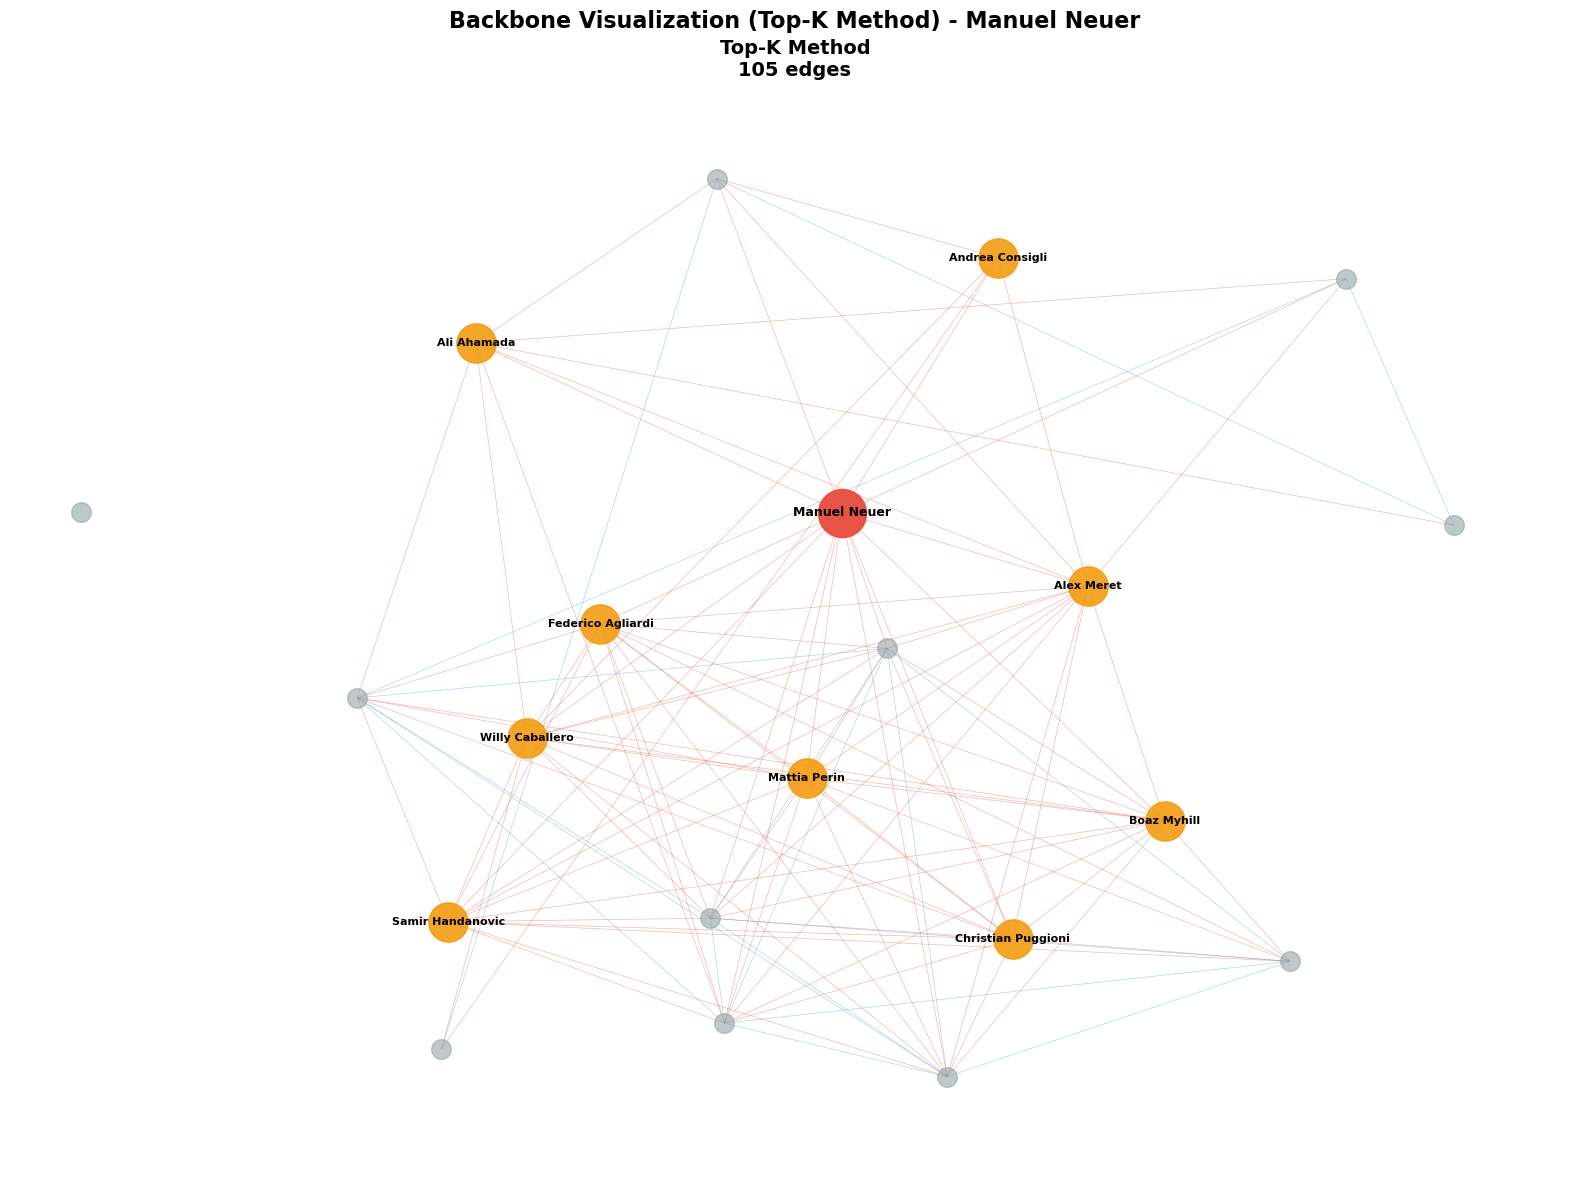

In [189]:
if 'G_original' in globals() and G_original is not None and len(G_original.nodes()) > 0:
        # Get player_name from previous execution or use default
        if 'player_name' not in globals():
            player_name = "Manuel Neuer"  # Default player name

        method = 'top_k'
        backbone = create_backbone_graph(G_original, method=method, alpha=0.05, top_edges=len(G_original.edges())//2)
        reduction = (1 - len(backbone.edges())/len(G_original.edges())) * 100
        print(f"\n{method.upper()} method:")
        print(f"  Nodes: {len(backbone.nodes())} ({len(backbone.nodes())/len(G_original.nodes())*100:.1f}% of original)")
        print(f"  Edges: {len(backbone.edges())} ({reduction:.1f}% reduction)")
        
        # Identify hubs
        hubs, hub_set = identify_hubs(G_original, top_k=10)
        
        # Visualize Top-K backbone method
        fig, ax = plt.subplots(1, 1, figsize=(16, 12))
        fig.suptitle(f'Backbone Visualization (Top-K Method) - {player_name}', 
                     fontsize=16, fontweight='bold', y=0.98)
        ax.set_facecolor('#f8f9fa')
        
        # Layout
        pos = nx.spring_layout(backbone, k=2, iterations=50, seed=42)
        
        # Draw edges
        edge_colors = []
        for u, v in backbone.edges():
            if u in hub_set or v in hub_set:
                edge_colors.append('#e74c3c')
            else:
                edge_colors.append('#3498db')
        
        nx.draw_networkx_edges(backbone, pos, ax=ax, edge_color=edge_colors, 
                              alpha=0.4, width=0.5, arrows=False)
        
        # Draw nodes
        regular_nodes = [n for n in backbone.nodes() if n not in hub_set and n != player_name]
        hub_nodes = [n for n in backbone.nodes() if n in hub_set and n != player_name]
        query_nodes = [n for n in backbone.nodes() if n == player_name]
        
        if regular_nodes:
            nx.draw_networkx_nodes(backbone, pos, nodelist=regular_nodes, ax=ax,
                                  node_color='#95a5a6', node_size=200, alpha=0.6)
        if hub_nodes:
            nx.draw_networkx_nodes(backbone, pos, nodelist=hub_nodes, ax=ax,
                                  node_color='#f39c12', node_size=800, alpha=0.9)
        if query_nodes:
            nx.draw_networkx_nodes(backbone, pos, nodelist=query_nodes, ax=ax,
                                  node_color='#e74c3c', node_size=1200, alpha=0.95)
        
        # Add labels for query player (black color)
        if query_nodes:
            query_labels = {node: node for node in query_nodes if node in backbone.nodes()}
            nx.draw_networkx_labels(backbone, pos, query_labels, ax=ax,
                                   font_size=9, font_weight='bold',
                                   font_color='black')
        
        # Add labels for hub nodes/similar players (black color)
        if hub_nodes:
            hub_labels = {node: node for node in hub_nodes if node in backbone.nodes()}
            nx.draw_networkx_labels(backbone, pos, hub_labels, ax=ax,
                                   font_size=8, font_weight='bold',
                                   font_color='black')
        
        ax.set_title(f'Top-K Method\n{len(backbone.edges())} edges', 
                    fontsize=14, fontweight='bold')
        ax.axis('off')
        
        plt.tight_layout()
        plt.show()

In [190]:
# Analyze the graph structure and community quality
if graph is not None and len(graph.nodes()) > 0:
    print(f"Number of nodes: {len(graph.nodes())}")
    print(f"Number of edges: {len(graph.edges())}")
    print(f"Graph density: {nx.density(graph):.4f}")
    print(f"Number of communities: {len(set(communities.values()))}")

    modularity = community_louvain.modularity(communities, graph)
    print(f"Modularity: {modularity:.4f} (higher is better, range: -1 to 1)")

    avg_clustering = nx.average_clustering(graph)
    print(f"Average Clustering Coefficient: {avg_clustering:.4f}")

Number of nodes: 21
Number of edges: 210
Graph density: 1.0000
Number of communities: 1
Modularity: 0.0000 (higher is better, range: -1 to 1)
Average Clustering Coefficient: 1.0000


## **TF-IDF Word Cloud Visualization by Position**

In [191]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import re


In [192]:
def display_player_names_wordcloud(position, df_data, show_top_6=True, max_players=100):
    if show_top_6:
        print(f"Top Most Common Positions")
    else:
        print(f"{position} Position")

    position_stats = df_data.groupby('position').agg({
        'rating': ['mean', 'count', 'std', 'min', 'max']
    }).reset_index()
    
    position_stats.columns = ['position', 'avg_rating', 'player_count', 'rating_std', 'min_rating', 'max_rating']
    
    # Sort by player count (most common) first, then by average rating
    position_stats = position_stats.sort_values(['player_count', 'avg_rating'], ascending=[False, False])
    
    if show_top_6:
        # Get top 6 most common positions
        top_6_positions = position_stats.head(6).copy()
        positions_to_show = top_6_positions
        n_cols = 3
        n_rows = 2
        figsize = (24, 14)
        
        # Print a note if input position is not in the top 6
        if position not in top_6_positions['position'].values:
            input_position_row = position_stats[position_stats['position'] == position]
            if len(input_position_row) > 0:
                input_rank = position_stats.reset_index(drop=True)
                input_rank = input_rank[input_rank['position'] == position].index[0] + 1
    else:
        # Show only the specified position
        position_row = position_stats[position_stats['position'] == position]
        if len(position_row) == 0:
            print(f"Position '{position}' not found in dataset.")
            return None, None
        positions_to_show = position_row
        n_cols = 1
        n_rows = 1
        figsize = (14, 10)
    
    print(f"{'Position':<12} {'Avg Rating':<12} {'Players':<10} {'Rating Range':<15}")
    print(f"{'-'*60}")
    for _, row in positions_to_show.iterrows():
        rating_range = f"{row['min_rating']:.1f}-{row['max_rating']:.1f}"
        print(f"{row['position']:<12} {row['avg_rating']:>10.2f}  {int(row['player_count']):<10} {rating_range:<15}")
    
    # Create figure with balanced layout: 3 columns x 2 rows = 3 top, 3 bottom
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, facecolor='#f8f9fa')
    
    # Flatten axes array for easy indexing
    if show_top_6:
        axes = axes.flatten()[:6]  # Ensure exactly 6 axes
    else:
        axes = [axes] if not isinstance(axes, np.ndarray) else axes.flatten()
    
    # Generate word clouds for each position
    for idx, (_, pos_row) in enumerate(positions_to_show.iterrows()):
        pos = pos_row['position']
        avg_rating = pos_row['avg_rating']
        player_count = int(pos_row['player_count'])
        min_rating = pos_row['min_rating']
        max_rating = pos_row['max_rating']
        
        ax = axes[idx]
        
        # Get all players for this position
        position_players = df_data[df_data['position'] == pos].copy()
        
        if len(position_players) == 0:
            ax.text(0.5, 0.5, f'No players found for {pos}', 
                   ha='center', va='center', fontsize=14, color='#7f8c8d')
            ax.set_title(f'{pos}', fontsize=12, fontweight='bold', color='#2c3e50')
            ax.axis('off')
            continue
        
        # Create dictionary of player names to ratings (for word cloud frequencies)
        # Higher rating = larger name in word cloud
        player_ratings = {}
        for _, player in position_players.iterrows():
            player_name = player['name']
            rating = player.get('rating', 0)
            if pd.notna(rating) and rating > 0:
                # Use rating as frequency (higher rating = more weight)
                # Scale rating to make it more visible in word cloud
                scaled_rating = rating ** 2  # Square to increase difference
                player_ratings[player_name] = float(scaled_rating)
        
        if len(player_ratings) == 0:
            ax.text(0.5, 0.5, f'No ratings found for {pos} players', 
                   ha='center', va='center', fontsize=14, color='#7f8c8d')
            ax.set_title(f'{pos}', fontsize=12, fontweight='bold', color='#2c3e50')
            ax.axis('off')
            continue
        
        # Sort players by rating and take top max_players
        sorted_players = sorted(player_ratings.items(), key=lambda x: x[1], reverse=True)
        top_players_dict = dict(sorted_players[:max_players])
        
        # Position-specific colors
        position_colors = {
            'GK': 'Reds', 'DF': 'Blues', 'M': 'Greens', 
            'FW': 'Oranges', 'MF': 'Purples', 'AM': 'YlOrRd',
            'CM': 'YlGn', 'DM': 'GnBu', 'CB': 'Blues',
            'LB': 'Greens', 'RB': 'Greens', 'LM': 'Oranges',
            'RM': 'Oranges', 'ST': 'Reds', 'LW': 'Purples',
            'RW': 'Purples', 'CDM': 'GnBu', 'CAM': 'YlOrRd',
            'LWB': 'Greens', 'RWB': 'Greens', 'D': 'Blues'
        }
        
        colormap = position_colors.get(pos, 'viridis')
        
        # Calculate size scaling based on position ranking (most common = larger)
        if show_top_6:
            # Most common position gets larger word clouds
            size_factor = 1.0 - (idx * 0.05)  # Decrease by 5% for each position
            size_factor = max(0.75, size_factor)  # Minimum 75% size
        else:
            size_factor = 1.0
        
        base_width = 1200
        base_height = 800
        width = int(base_width * size_factor)
        height = int(base_height * size_factor)
        max_font = int(90 * size_factor)
        min_font = int(10 * size_factor)
        
        # Create word cloud from player names and ratings
        wordcloud = WordCloud(
            width=width, height=height,
            background_color='white',
            colormap=colormap,
            max_words=max_players,
            relative_scaling=0.5,
            min_font_size=min_font,
            max_font_size=max_font,
            random_state=42,
            collocations=False,
            prefer_horizontal=0.6,
            scale=2
        ).generate_from_frequencies(top_players_dict)
        
        # Display word cloud
        ax.imshow(wordcloud, interpolation='bilinear')
        
        # Create simple title with just position name and stats
        title = f'{pos}\n'
        title += f'Avg Rating: {avg_rating:.2f} | Players: {player_count} | Range: {min_rating:.1f}-{max_rating:.1f}'
        
        ax.set_title(title, fontsize=14, fontweight='bold', pad=10, color='#2c3e50')
        ax.axis('off')
    
    # Hide unused subplots
    if show_top_6:
        for idx in range(len(positions_to_show), len(axes)):
            axes[idx].axis('off')
    
    # Adjust layout for balanced 3x2 grid with tight spacing and larger word clouds
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    # Tighter spacing: smaller hspace and wspace values = less space between plots
    plt.subplots_adjust(hspace=0.15, wspace=0.10, top=0.94, bottom=0.03, left=0.02, right=0.98)
    plt.show()
    
    return fig, positions_to_show


In [193]:
def display_position_wordcloud(position, df_data, feature_names=None,
                               max_features=40, compare_with_others=True,
                               show_top_6=True, show_player_names=True):
    if not show_player_names:
        counts = df_data['position'].value_counts()
        if position in counts:
            print(f"Total {position} players: {counts[position]}")
    
    return display_player_names_wordcloud(position, df_data, show_top_6, max_features)


In [197]:
def create_wordcloud_for_player_position(player_name, df_data):
    player_row = df_data[df_data['name'] == player_name]
    if len(player_row) == 0:
        # Try case-insensitive match
        player_row = df_data[df_data['name'].str.lower() == player_name.lower()]
        if len(player_row) == 0:
            raise ValueError(f"Player '{player_name}' not found")
    
    position = player_row.iloc[0]['position']
    print(f"Player '{player_name}' is a {position}")
    
    return display_position_wordcloud(position, df_data, show_top_6=False)

Top Most Common Positions
Position     Avg Rating   Players    Rating Range   
------------------------------------------------------------
M                  7.19  1753       7.0-8.3        
FW                 7.30  1283       7.0-8.9        
D                  7.17  1167       7.0-7.8        
DM                 7.17  317        7.0-7.7        
GK                 7.12  125        7.0-7.7        
AM                 7.18  124        7.0-7.6        


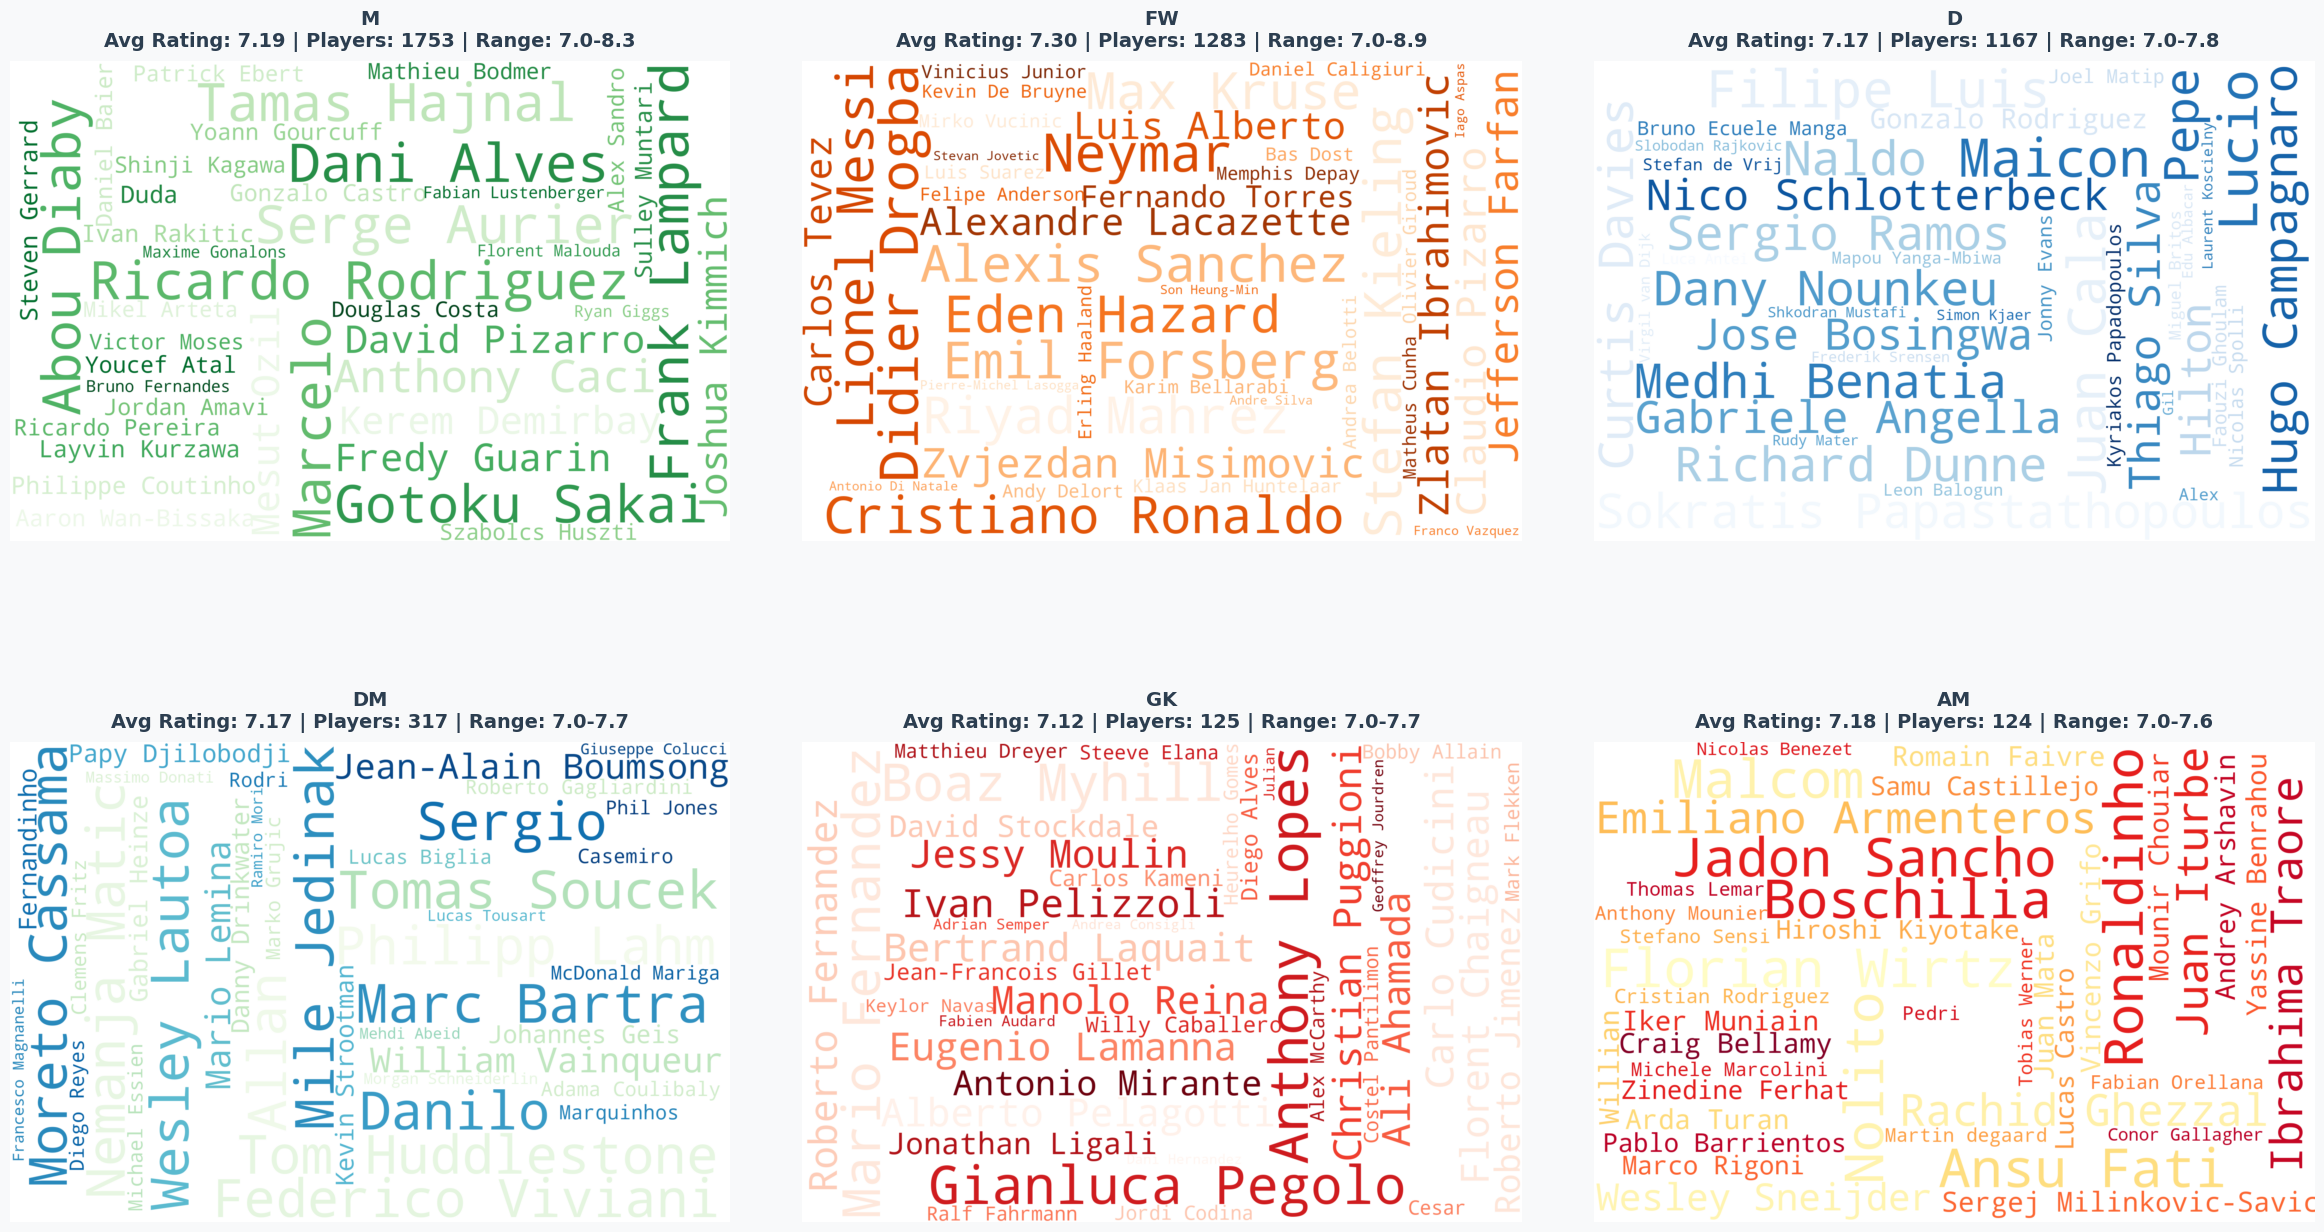

In [198]:
fig, stats = display_position_wordcloud("GK", df_data=df_full, show_top_6=True)

Player 'Manuel Neuer' is a GK
GK Position
Position     Avg Rating   Players    Rating Range   
------------------------------------------------------------
GK                 7.12  125        7.0-7.7        


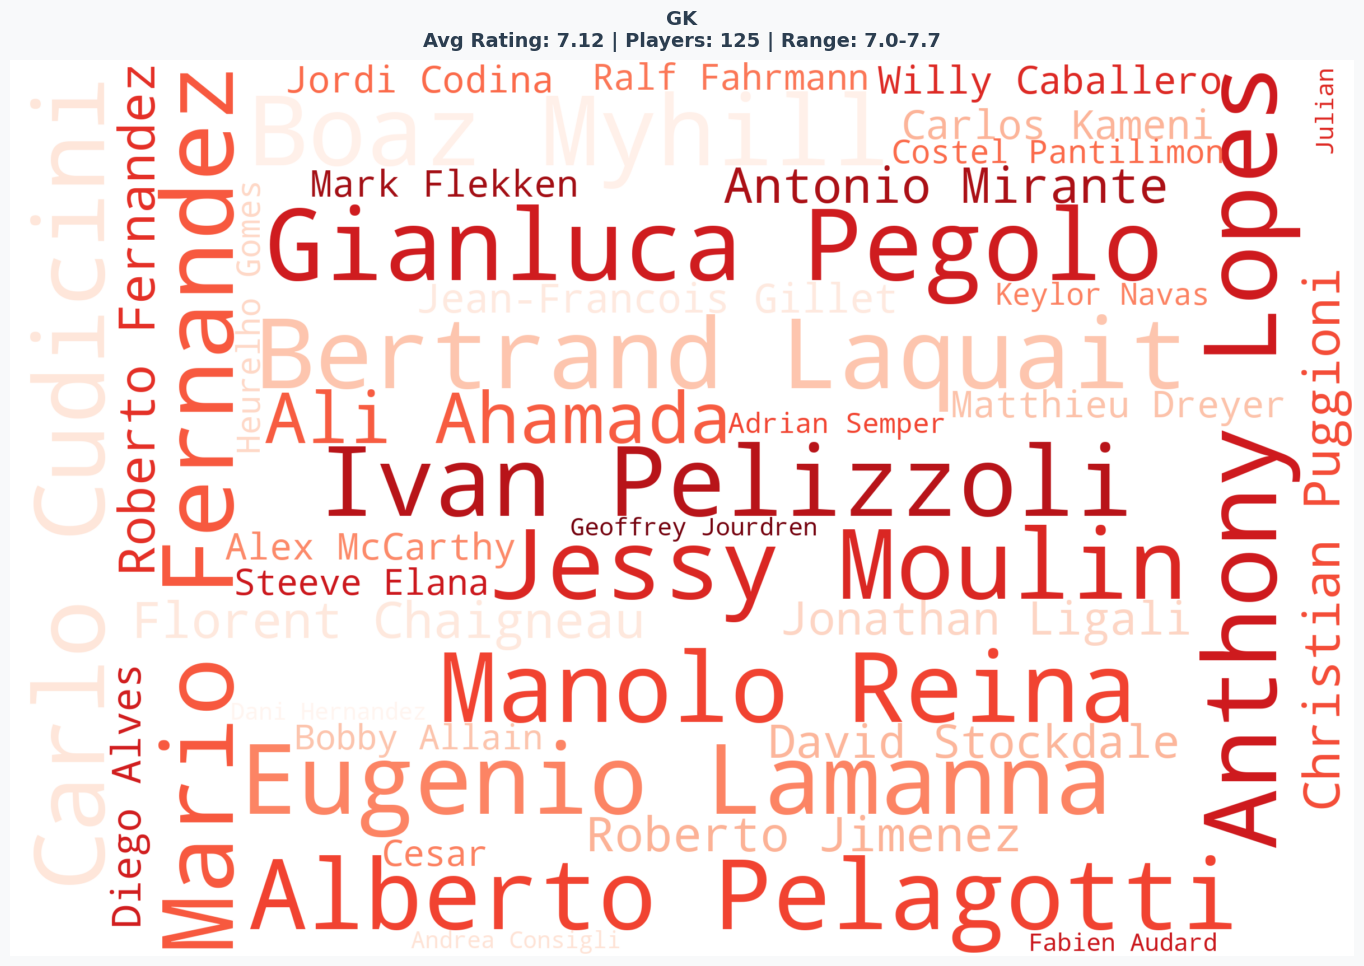

In [199]:
player_name = "Manuel Neuer"
fig, stats = create_wordcloud_for_player_position(player_name, df_data=df_full)